In [1]:
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
from scipy.stats import multivariate_normal

from utils.AriaDataset import AriaDataset
from utils.config import get_config
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils.visualize import visualize_hard, visualize_soft

In [2]:
config = get_config()

In [3]:
test_set = AriaDataset(config, train=False)
test_loader = DataLoader(
    test_set,
    batch_size=config["batch_size"],
    shuffle=False,
    drop_last=False,
)


/Users/jkosciukiewicz/Developer/UJ/Classes/PatternRecognition/utils/AriaDataset.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(processed_file)


In [4]:
# writer = SummaryWriter(
#     log_dir='/Users/jkosciukiewicz/Developer/UJ/Classes/PatternRecognition/logs/test'
# )

In [5]:
def mock_soft_gaze(y_true, num_frames, grid_size=224, stddev=10, noise_level=0.05):
    """
    Generate soft gaze heatmaps for each frame based on true gaze points.

    Args:
        y_true: Tensor of ground truth coordinates [batch_size, num_frames, 2].
        num_frames: Number of frames to consider.
        grid_size: Size of the output heatmap (grid_size x grid_size).
        stddev: Standard deviation of the Gaussian distribution.
        noise_level: Noise level for generating predictions and heatmap variation.

    Returns:
        heatmaps: Tensor of heatmaps with shape [batch_size, num_frames, grid_size, grid_size].
    """
    # Generate mock predictions (y_pred) close to y_true
    noise = torch.rand_like(y_true) * 2 * noise_level - noise_level
    y_pred = y_true + noise
    y_pred = y_pred.clamp(0.0, 1.0)  # Ensure predictions stay in range [0, 1]

    batch_size = y_true.shape[0]
    heatmaps = []

    # Create a grid for the heatmap
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    xx, yy = np.meshgrid(x, y)

    for batch_idx in range(batch_size):
        frame_heatmaps = []
        for frame_idx in range(num_frames):
            # Get the predicted gaze point for this frame
            center = y_pred[batch_idx, frame_idx].detach().cpu().numpy()
            mean = [center[0] * grid_size, center[1] * grid_size]  # Scale to grid size
            cov = [[stddev**2, 0], [0, stddev**2]]  # Covariance matrix

            # Create a Gaussian heatmap
            pos = np.dstack((xx * grid_size, yy * grid_size))
            gaussian = multivariate_normal(mean, cov).pdf(pos)

            # Normalize the heatmap
            gaussian /= gaussian.max()

            # Add noise
            noise = np.random.uniform(-noise_level, noise_level, size=gaussian.shape)
            heatmap = np.clip(gaussian + noise, 0, 1)  # Ensure values stay in range [0, 1]

            frame_heatmaps.append(heatmap)

        heatmaps.append(frame_heatmaps)

    heatmaps = torch.tensor(heatmaps, dtype=torch.float32)
    return heatmaps

def mock_hard_gaze(y_true, num_frames, noise_level=0.05):
    """
    Generate mock predictions for gaze points close to the true values.

    Args:
        y_true: Tensor of ground truth coordinates [batch_size, 2] or [batch_size, num_frames, 2]
        num_frames: Number of frames to consider. If >1, y_pred shape will include the frames dimension.
        noise_level: The maximum amount of noise to add to the true gaze points.

    Returns:
        y_pred: Tensor of predicted gaze points. Shape matches the input shape of y_true.
    """
    if y_true.dim() == 3:  # Handle [batch_size, num_frames, 2]
        noise = torch.rand_like(y_true) * 2 * noise_level - noise_level
        y_pred = y_true + noise
    else:  # Handle [batch_size, 2]
        noise = torch.rand_like(y_true) * 2 * noise_level - noise_level
        y_pred = y_true + noise

    # Clip the predictions to ensure they stay within the valid range [0, 1]
    y_pred = y_pred.clamp(0.0, 1.0)
    return y_pred

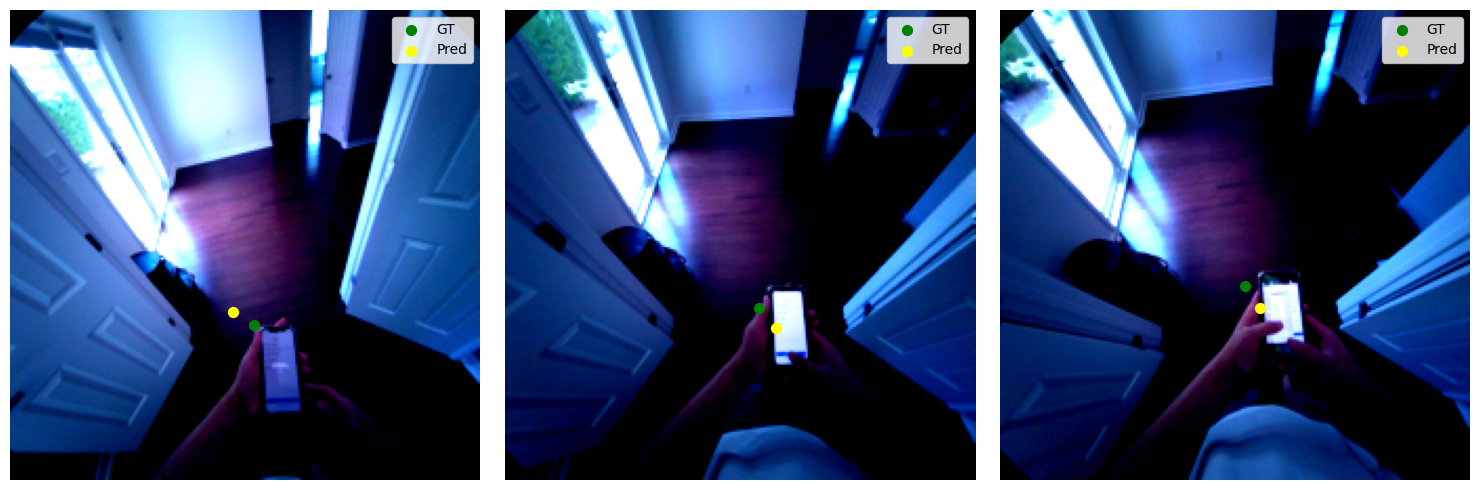

In [6]:
X, y = next(iter(test_loader))
y_pred=mock_hard_gaze(y, config['frame_grabber'])
# Get first items from the batch
X_i = X[0]
y_i = y[0]
y_pred_i = y_pred[0]
visualize_hard(X=X_i, y=y_i, y_pred=y_pred_i, num_frames=config['frame_grabber'])
#writer.close()

/var/folders/h5/c1fg9pqx7rvd63glykqthsg40000gn/T/ipykernel_10626/1475233413.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  heatmaps = torch.tensor(heatmaps, dtype=torch.float32)


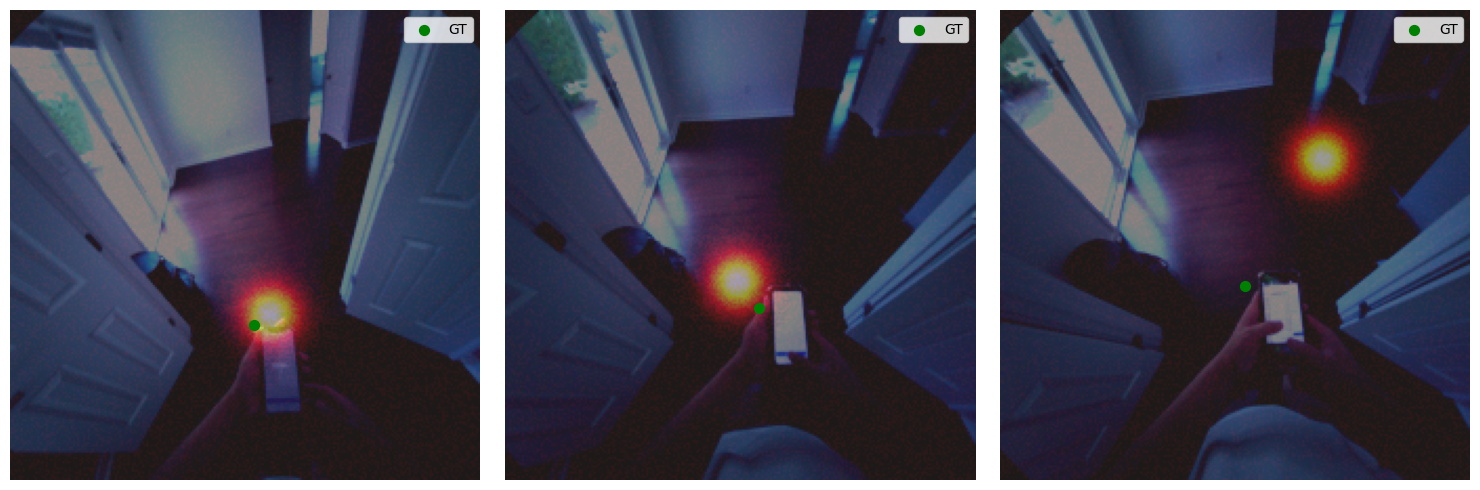

In [7]:
X, y = next(iter(test_loader))
heatmap=mock_soft_gaze(y, config['frame_grabber'])
# Get first items from the batch
X_i = X[0]
y_i = y[0]
visualize_soft(X=X_i, y=y_i, heatmaps=heatmap, num_frames=config['frame_grabber'])